# Auto_scout project Balint - Part 1: cleaning

In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [228]:
# Load the data
df = pd.read_json(r'C:\Users\BalintStewart\OneDrive - Health Data Research\Desktop\magnimind-assignments\Auto_scout\data\scout_car.json', lines=True) # lines=True reads the file as lines of JSON (one JSON object per line)

df.shape

(15919, 54)

In [229]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15919 entries, 0 to 15918
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            15919 non-null  object 
 1   make_model                     15919 non-null  object 
 2   short_description              15873 non-null  object 
 3   body_type                      15859 non-null  object 
 4   price                          15919 non-null  int64  
 5   vat                            11406 non-null  object 
 6   km                             15919 non-null  object 
 7   registration                   15919 non-null  object 
 8   prev_owner                     9091 non-null   object 
 9   kW                             0 non-null      float64
 10  hp                             15919 non-null  object 
 11  Type                           15917 non-null  object 
 12  Previous Owners                9279 non-null  

In [230]:
df.describe()

,price,kW
count,15919.000000,0.0
mean,18019.896727,NaN
std,7386.169409,NaN
min,13.000000,NaN
25%,12850.000000,NaN
50%,16900.000000,NaN
75%,21900.000000,NaN
max,74600.000000,NaN


## Drop columns containing >90% missing values

In [231]:
# Find proportion of missing values for each column
percent_missing = df.isna().sum()/len(df)*100

# Select columns that have >90% missing values, drop these from the data
high_missing = percent_missing[percent_missing >90].index
df = df.drop(high_missing, axis = 1)
df.shape

(15919, 47)

In [232]:
df.isna().sum()/len(df)*100


url                           0.000000
make_model                    0.000000
short_description             0.288963
body_type                     0.376908
price                         0.000000
vat                          28.349771
km                            0.000000
registration                  0.000000
prev_owner                   42.892141
hp                            0.000000
Type                          0.012564
Previous Owners              41.711163
Next Inspection              77.793831
Inspection new               75.299956
Warranty                     34.047365
Full Service                 48.395000
Non-smoking Vehicle          54.915510
null                          0.000000
Make                          0.000000
Model                         0.000000
Offer Number                 19.944720
First Registration           10.032037
Body Color                    3.750236
Paint Type                   36.258559
Body Color Original          23.613292
Upholstery               

## Tidy up column names
- Make them all lower case
- join words using underscore
- clean up col name strings (remove leaading and trailing '\n'))

In [233]:
# Clean up column names
df.columns = df.columns.str.strip().str.lower().str.replace(r'\n','').str.replace('&','_').str.replace(' ','').str.replace('.','')
df.columns

Index(['url', 'make_model', 'short_description', 'body_type', 'price', 'vat',
       'km', 'registration', 'prev_owner', 'hp', 'type', 'previousowners',
       'nextinspection', 'inspectionnew', 'warranty', 'fullservice',
       'non-smokingvehicle', 'null', 'make', 'model', 'offernumber',
       'firstregistration', 'bodycolor', 'painttype', 'bodycolororiginal',
       'upholstery', 'body', 'nrofdoors', 'nrofseats', 'modelcode',
       'gearingtype', 'displacement', 'cylinders', 'weight', 'drivechain',
       'fuel', 'consumption', 'co2emission', 'emissionclass',
       'comfort_convenience', 'entertainment_media', 'extras',
       'safety_security', 'description', 'emissionlabel', 'gears',
       'countryversion'],
      dtype='object')

## Compare 'make_model' with 'make' and 'model' columns

In [234]:
dfmm = df[['make_model', 'make', 'model']]
dfmm.sample(10)

# Should I keep 'make' and 'model' as separate features or just 'make_model'? Want to avoid redundancy/multicolinearity in my training dataset.
print(dfmm.make_model.value_counts(dropna=False)) 

# Final decision: keep 'make_model' and drop 'make' and 'model' - simplifies the feauture set more than onehotencoding both 'make' and 'model'
df = df.drop(['make','model'], axis = 1)


make_model
Audi A3           3097
Audi A1           2614
Opel Insignia     2598
Opel Astra        2526
Opel Corsa        2219
Renault Clio      1839
Renault Espace     991
Renault Duster      34
Audi A2              1
Name: count, dtype: int64


## Compare and clean/combine prev_owner and previousowners

In [235]:
df[['prev_owner', 'previousowners']].sample(10)
print(df.prev_owner.value_counts(dropna = False))
print(df.previousowners.value_counts(dropna= False))

prev_owner
1 previous owner     8294
None                 6828
2 previous owners     778
3 previous owners      17
4 previous owners       2
Name: count, dtype: int64
previousowners
\n1\n                                                                                        8101
NaN                                                                                          6640
\n2\n                                                                                         766
\n0\n                                                                                         163
\n3\n                                                                                          17
                                                                                             ... 
[\n1\n, \n85 g CO2/km (comb)\n]                                                                 1
[\n1\n, \n, 5.9 l/100 km (comb), \n, 7.6 l/100 km (city), \n, 5.1 l/100 km (country), \n]       1
[\n1\n, \n188 g CO2/km (comb)\n]  

In [236]:
# clean previousowners column 
df['previousowners_cleaned'] = df['previousowners'].str.replace('\n', '')



In [237]:
# clean prev_owner column: remove strings after number, and convert 'None' to np.nan
def clean_prev_owner(value):
    if isinstance(value, str):
        return value.split()[0] # value.split() splits the string into ['1', 'previous', 'owners'], then select first element 
    if value == 'None' or pd.isna(value):
        return np.nan
    return value

df['prev_owner_cleaned'] = df['prev_owner'].apply(clean_prev_owner)
df['prev_owner_cleaned'].value_counts(dropna= False)

prev_owner_cleaned
1      8294
NaN    6828
2       778
3        17
4         2
Name: count, dtype: int64

In [238]:
# Check the NaN discrepancy across the two columns
discrep = df[df['prev_owner_cleaned'] != df['previousowners_cleaned']]
discrep[['prev_owner_cleaned','previousowners_cleaned']].dropna()
# All discrepencies involve an NaN in one of the columns

,prev_owner_cleaned,previousowners_cleaned


In [239]:
# Have a look at the NaN discrepencies
filtered_df = df[(df['prev_owner_cleaned'].isna() & df['previousowners_cleaned'].notna()) | (df['prev_owner_cleaned'].notna() & df['previousowners_cleaned'].isna())]
filtered_df[['prev_owner_cleaned','previousowners_cleaned']] 

,prev_owner_cleaned,previousowners_cleaned
47,NaN,0
418,NaN,0
586,NaN,0
648,NaN,0
734,NaN,0
...,...,...
15794,1,NaN
15853,NaN,0
15860,NaN,0
15915,1,NaN


In [240]:
# Some values are NaN in one, and value in the other, and vice versa. Merge so that we keep the value and discard the NaN these instances by using combine_first
# Now merge the two columns together
df['previous_owners_cleaned'] = df['prev_owner_cleaned'].combine_first(df['previousowners_cleaned'])
df['previous_owners_cleaned'].value_counts(dropna = False)


previous_owners_cleaned
1      8294
NaN    6665
2       778
0       163
3        17
4         2
Name: count, dtype: int64

In [241]:
# Drop columns not needed anymore
df = df.drop(['prev_owner_cleaned','previousowners_cleaned','prev_owner', 'previousowners'], axis = 1)

## 'Null' column

In [242]:
print(df['null'].value_counts(dropna = False))
# Drop the 'null' column
df = df.drop('null', axis = 1)

null
[]    15919
Name: count, dtype: int64


In [243]:
df.columns

Index(['url', 'make_model', 'short_description', 'body_type', 'price', 'vat',
       'km', 'registration', 'hp', 'type', 'nextinspection', 'inspectionnew',
       'warranty', 'fullservice', 'non-smokingvehicle', 'offernumber',
       'firstregistration', 'bodycolor', 'painttype', 'bodycolororiginal',
       'upholstery', 'body', 'nrofdoors', 'nrofseats', 'modelcode',
       'gearingtype', 'displacement', 'cylinders', 'weight', 'drivechain',
       'fuel', 'consumption', 'co2emission', 'emissionclass',
       'comfort_convenience', 'entertainment_media', 'extras',
       'safety_security', 'description', 'emissionlabel', 'gears',
       'countryversion', 'previous_owners_cleaned'],
      dtype='object')

## Compare 'co2emission', 'emissionclass', 'emissionlabel' columns

In [244]:
df[['co2emission', 'emissionclass', 'emissionlabel']]
df['emissionlabel'].value_counts(dropna = False)

emissionlabel
NaN                     11934
[\n4 (Green)\n]          3553
[\n1 (No sticker)\n]      381
[[], [], []]               40
[\n5 (Blue)\n]              8
[\n3 (Yellow)\n]            2
[\n2 (Red)\n]               1
Name: count, dtype: int64

## Co2 emission

In [245]:
def cleann_column(series):
    # Convert the series to string type
    series = series.astype(str)
    # Strip unwanted characters and replace newlines
    return series.str.strip('[]\\n').str.replace('\\n', '', regex=False)

# Apply the cleaning function to each column
df['co2emission'] = cleann_column(df['co2emission'])
df['emissionclass'] = cleann_column(df['emissionclass'])
df['emissionlabel'] = cleann_column(df['emissionlabel'])


In [246]:
import re
# Define a function to clean the emission values
def extract_int(value):
    if isinstance(value, str):
        # Remove any unwanted characters and extract the numeric part
        value = re.sub(r'[^\d]', '', value)  # Remove everything except digits
        return int(value) if value else np.nan  # Convert to int or return NaN if empty
    return np.nan

# Apply the cleaning function to the column
df['co2emission_cleaned_gCO2/km'] = df['co2emission'].apply(extract_int)
df['co2emission_cleaned_gCO2/km'].value_counts(dropna=False)

co2emission_cleaned_gCO2/km
NaN       2436
1202.0     740
992.0      545
972.0      537
1042.0     501
          ... 
1802.0       1
1712.0       1
1832.0       1
12.0         1
1932.0       1
Name: count, Length: 123, dtype: int64

## emissionlabel column

In [247]:
df['emissionlabel'].value_counts()
df['emissionlabel'] =df['emissionlabel'].str.strip()
# define values to make np.nan
values_to_nan = ['a', ', [],']

# Replace these values with np.nan
df['emissionlabel'] = df['emissionlabel'].replace(values_to_nan, np.nan) # not sure why this returns string nan, need NaN! 
df['emissionlabel'] = df['emissionlabel'].replace('nan', np.nan)
df['emissionlabel'].value_counts(dropna = False)


emissionlabel
NaN                 11974
'4 (Green)'          3553
'1 (No sticker)'      381
'5 (Blue)'              8
'3 (Yellow)'            2
'2 (Red)'               1
Name: count, dtype: int64

In [248]:
import re
# Define a function to extract the color (I think this is more meaningful than a category number?)
def extract_color(label):
    match = re.search(r'\(([^)]+)\)', label)
    return match.group(1) if match else np.nan

# convert column to string
df['emissionlabel'] = df['emissionlabel'].astype(str)
# Apply the function to the column
df['emissionlabel_cleaned'] = df['emissionlabel'].apply(extract_color)

# Check the cleaned values
print(df['emissionlabel_cleaned'].value_counts(dropna=False))

# Should we convert 'No sticker' to NaN? Depends if 'no sticker' is the same as 'unknown sticker' (assuming NaN is 'unknown sticker')

emissionlabel_cleaned
NaN           11974
Green          3553
No sticker      381
Blue              8
Yellow            2
Red               1
Name: count, dtype: int64


## emissionclass column


In [249]:
# Remove Euro and -TEMP from beginning and end of values
df['emissionclass'] =df['emissionclass'].str.replace('Euro','').str.replace('-TEMP', '')
# strip leading/trailing whitespace
df['emissionclass'] =df['emissionclass'].str.strip()
# Convert 'a' and ', []' to NaN
values_to_nan = ['a', ', [],']
# Replace these values with np.nan
df['emissionclass_cleaned'] = df['emissionclass'].replace(values_to_nan, np.nan) # not sure why this returns string nan, need NaN! 
df['emissionclass_cleaned'].value_counts(dropna = False)


emissionclass_cleaned
' 6'     10139
NaN       3628
' 6d'     1907
' 6c'      127
' 5'        78
' 4'        40
Name: count, dtype: int64

In [250]:
# Drop emissionclass, emissionlabel, and co2emission columns
df = df.drop(['emissionclass', 'emissionlabel', 'co2emission'], axis = 1)
df.columns

Index(['url', 'make_model', 'short_description', 'body_type', 'price', 'vat',
       'km', 'registration', 'hp', 'type', 'nextinspection', 'inspectionnew',
       'warranty', 'fullservice', 'non-smokingvehicle', 'offernumber',
       'firstregistration', 'bodycolor', 'painttype', 'bodycolororiginal',
       'upholstery', 'body', 'nrofdoors', 'nrofseats', 'modelcode',
       'gearingtype', 'displacement', 'cylinders', 'weight', 'drivechain',
       'fuel', 'consumption', 'comfort_convenience', 'entertainment_media',
       'extras', 'safety_security', 'description', 'gears', 'countryversion',
       'previous_owners_cleaned', 'co2emission_cleaned_gCO2/km',
       'emissionlabel_cleaned', 'emissionclass_cleaned'],
      dtype='object')

## Compare 'body_type','body' columns

In [251]:
df[['body_type', 'body']].sample(20)

,body_type,body
4953,Sedans,"[\n, Sedans, \n]"
14711,Compact,"[\n, Compact, \n]"
3803,Sedans,"[\n, Sedans, \n]"
7750,Station wagon,"[\n, Station wagon, \n]"
713,Sedans,"[\n, Sedans, \n]"
14464,Sedans,"[\n, Sedans, \n]"
1754,Sedans,"[\n, Sedans, \n]"
9391,Sedans,"[\n, Sedans, \n]"
10997,Sedans,"[\n, Sedans, \n]"
4675,Other,"[\n, Other, \n]"


In [252]:
# Create a function similar to cleann_column that also removes ','
def clean_column(series):
    series = series.astype(str)
    # Strip unwanted characters and replace newlines
    return series.str.split(',').str[1].str.strip(" \n[]'")

In [253]:
# body_type and 'body' look very similar, clean 'body' and then check
df['body_cleaned'] = clean_column(df['body'])
df['body_cleaned'].value_counts(dropna =False)

body_cleaned
Sedans           7903
Station wagon    3553
Compact          3153
Van               783
Other             290
Transporter        88
NaN                60
Off-Road           56
Coupe              25
Convertible         8
Name: count, dtype: int64

In [254]:
# Check body_type
df['body_type'].value_counts(dropna = False)
# body_type identical to body_cleaned, so keep body_cleaned
df = df.drop('body_type', axis = 1)

## Compare'bodycolor', 'bodycolororiginal' columns

In [255]:
df[['bodycolor', 'bodycolororiginal']]



,bodycolor,bodycolororiginal
0,"[\n, Black, \n]",[\nMythosschwarz\n]
1,"[\n, Red, \n]",NaN
2,"[\n, Black, \n]",[\nmythosschwarz metallic\n]
3,"[\n, Brown, \n]",NaN
4,"[\n, Black, \n]",[\nMythosschwarz Metallic\n]
...,...,...
15914,"[\n, Grey, \n]",[\nGrigio scuro\n]
15915,"[\n, Grey, \n]",[\nStahl-Grau Metallic\n]
15916,"[\n, White, \n]",[\narktis-weiß\n]
15917,"[\n, Grey, \n]",[\nGrigio\n]


In [256]:
# Clean the bodycolor feature
df['bodycolor_cleaned'] = clean_column(df['bodycolor'])
df['bodycolor_cleaned'].value_counts(dropna=False)

bodycolor_cleaned
Black     3745
Grey      3505
White     3406
Silver    1647
Blue      1431
Red        957
NaN        597
Brown      289
Green      154
Beige      108
Yellow      51
Violet      18
Bronze       6
Orange       3
Gold         2
Name: count, dtype: int64

In [257]:
# Drop the bodycolororiginal column - lots of NaNs and useful information all in 'bodycolor_cleaned' variable now
df = df.drop('bodycolororiginal', axis = 1)

In [258]:
df.columns

Index(['url', 'make_model', 'short_description', 'price', 'vat', 'km',
       'registration', 'hp', 'type', 'nextinspection', 'inspectionnew',
       'warranty', 'fullservice', 'non-smokingvehicle', 'offernumber',
       'firstregistration', 'bodycolor', 'painttype', 'upholstery', 'body',
       'nrofdoors', 'nrofseats', 'modelcode', 'gearingtype', 'displacement',
       'cylinders', 'weight', 'drivechain', 'fuel', 'consumption',
       'comfort_convenience', 'entertainment_media', 'extras',
       'safety_security', 'description', 'gears', 'countryversion',
       'previous_owners_cleaned', 'co2emission_cleaned_gCO2/km',
       'emissionlabel_cleaned', 'emissionclass_cleaned', 'body_cleaned',
       'bodycolor_cleaned'],
      dtype='object')

** Look at price (target variable?) and vat columns


<Axes: ylabel='price'>

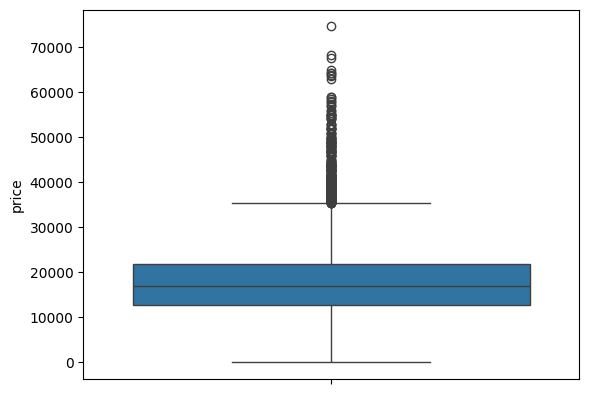

In [259]:
sns.boxplot(df['price'])

In [260]:
df['vat'].value_counts(dropna= False)

vat
VAT deductible      10980
None                 4513
Price negotiable      426
Name: count, dtype: int64

## km column

In [261]:
df['km'].value_counts(dropna= False)

km
10 km        1045
- km         1024
1 km          367
5 km          170
50 km         148
             ... 
10,227 km       1
10,803 km       1
14,328 km       1
22,987 km       1
15,042 km       1
Name: count, Length: 6690, dtype: int64

In [262]:
# drop 'km' and convert to integer
df['km'] = df['km'].str.replace(' km','').str.replace(',','').str.replace('-','')
df['km_cleaned'] = pd.to_numeric(df['km']).astype('Int64')
df['km_cleaned'].sample(10)

df = df.drop('km', axis = 1)


In [263]:
## VAT column

In [264]:
df['vat'].value_counts(dropna = False)

vat
VAT deductible      10980
None                 4513
Price negotiable      426
Name: count, dtype: int64

In [265]:
# Convert 'None' to np.NaN
df['vat_cleaned'] = df['vat'].replace([None, 'None', ' None', ' None '], np.nan)
df = df.drop('vat', axis = 1)

## Registration column

In [271]:
df['registration'].value_counts(dropna = False)
# Convert -/- to np.nan
df['registration'] = df['registration'].replace('-/-', np.nan)

In [274]:
# convert feature to datetime data type
df['registration_cleaned'] = pd.to_datetime(df['registration'])
df.drop('registration', axis = 1)

,url,make_model,short_description,price,hp,type,nextinspection,inspectionnew,warranty,fullservice,...,countryversion,previous_owners_cleaned,co2emission_cleaned_gCO2/km,emissionlabel_cleaned,emissionclass_cleaned,body_cleaned,bodycolor_cleaned,km_cleaned,vat_cleaned,registration_cleaned
0,https://www.autoscout24.com//offers/audi-a1-sp...,Audi A1,Sportback 1.4 TDI S-tronic Xenon Navi Klima,15770,66 kW,"[, Used, , Diesel (Particulate Filter)]","[\n06/2021\n, \n99 g CO2/km (comb)\n]","[\nYes\n, \nEuro 6\n]","[\n, \n, \n4 (Green)\n]","[\n, \n]",...,NaN,2,992.0,NaN,' 6',Sedans,Black,56013,VAT deductible,2016-01-01
1,https://www.autoscout24.com//offers/audi-a1-1-...,Audi A1,1.8 TFSI sport,14500,141 kW,"[, Used, , Gasoline]",NaN,NaN,NaN,NaN,...,NaN,NaN,1292.0,Green,' 6',Sedans,Red,80000,Price negotiable,2017-03-01
2,https://www.autoscout24.com//offers/audi-a1-sp...,Audi A1,Sportback 1.6 TDI S tronic Einparkhilfe plus+m...,14640,85 kW,"[, Used, , Diesel (Particulate Filter)]",NaN,NaN,"[\n, \n, \n99 g CO2/km (comb)\n]",NaN,...,NaN,1,992.0,Green,' 6',Sedans,Black,83450,VAT deductible,2016-02-01
3,https://www.autoscout24.com//offers/audi-a1-1-...,Audi A1,1.4 TDi Design S tronic,14500,66 kW,"[, Used, , Diesel (Particulate Filter)]",NaN,NaN,NaN,"[\n, \n, \n99 g CO2/km (comb)\n]",...,NaN,1,992.0,NaN,' 6',Sedans,Brown,73000,NaN,2016-08-01
4,https://www.autoscout24.com//offers/audi-a1-sp...,Audi A1,Sportback 1.4 TDI S-Tronic S-Line Ext. admired...,16790,66 kW,"[, Used, , Diesel (Particulate Filter)]",NaN,"[\nYes\n, \n109 g CO2/km (comb)\n]","[\n, \n, \nEuro 6\n]","[\n, \n, \n4 (Green)\n]",...,[\nGermany\n],1,1092.0,NaN,' 6',Sedans,Black,16200,NaN,2016-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15914,https://www.autoscout24.com//offers/renault-es...,Renault Espace,Blue dCi 200CV EDC Executive 4Control,39950,147 kW,"[, New, , Diesel (Particulate Filter)]",NaN,NaN,\n24 months\n,NaN,...,NaN,NaN,1392.0,NaN,NaN,Van,Grey,<NA>,VAT deductible,NaT
15915,https://www.autoscout24.com//offers/renault-es...,Renault Espace,"TCe 225 EDC GPF LIM Deluxe Pano,RFK",39885,165 kW,"[, Used, , Super 95 / Super Plus 98 (Particula...","[\n01/2022\n, \n168 g CO2/km (comb)\n]",NaN,"[\n, \n, \nEuro 6\n]",NaN,...,[\nGermany\n],1,1682.0,NaN,NaN,Van,Grey,9900,VAT deductible,2019-01-01
15916,https://www.autoscout24.com//offers/renault-es...,Renault Espace,Blue dCi 200 EDC Initiale Paris Leder LED Navi...,39875,146 kW,"[, Pre-registered, , Diesel]",NaN,"[\nYes\n, \nEuro 6d-TEMP\n]","[\n, \n, \n4 (Green)\n]","[\n, \n]",...,[\nAustria\n],1,1392.0,NaN,' 6d',Van,White,15,VAT deductible,2019-03-01
15917,https://www.autoscout24.com//offers/renault-es...,Renault Espace,"Blue dCi 200CV EDC Business , NUOVA DA IMMATRI...",39700,147 kW,"[, Pre-registered, , Diesel]",NaN,NaN,\n,NaN,...,NaN,NaN,1392.0,NaN,' 6',Van,Grey,10,VAT deductible,2019-06-01


In [266]:
df.head()

,url,make_model,short_description,price,registration,hp,type,nextinspection,inspectionnew,warranty,...,gears,countryversion,previous_owners_cleaned,co2emission_cleaned_gCO2/km,emissionlabel_cleaned,emissionclass_cleaned,body_cleaned,bodycolor_cleaned,km_cleaned,vat_cleaned
0,https://www.autoscout24.com//offers/audi-a1-sp...,Audi A1,Sportback 1.4 TDI S-tronic Xenon Navi Klima,15770,01/2016,66 kW,"[, Used, , Diesel (Particulate Filter)]","[\n06/2021\n, \n99 g CO2/km (comb)\n]","[\nYes\n, \nEuro 6\n]","[\n, \n, \n4 (Green)\n]",...,NaN,NaN,2,992.0,NaN,' 6',Sedans,Black,56013,VAT deductible
1,https://www.autoscout24.com//offers/audi-a1-1-...,Audi A1,1.8 TFSI sport,14500,03/2017,141 kW,"[, Used, , Gasoline]",NaN,NaN,NaN,...,[\n7\n],NaN,NaN,1292.0,Green,' 6',Sedans,Red,80000,Price negotiable
2,https://www.autoscout24.com//offers/audi-a1-sp...,Audi A1,Sportback 1.6 TDI S tronic Einparkhilfe plus+m...,14640,02/2016,85 kW,"[, Used, , Diesel (Particulate Filter)]",NaN,NaN,"[\n, \n, \n99 g CO2/km (comb)\n]",...,NaN,NaN,1,992.0,Green,' 6',Sedans,Black,83450,VAT deductible
3,https://www.autoscout24.com//offers/audi-a1-1-...,Audi A1,1.4 TDi Design S tronic,14500,08/2016,66 kW,"[, Used, , Diesel (Particulate Filter)]",NaN,NaN,NaN,...,[\n6\n],NaN,1,992.0,NaN,' 6',Sedans,Brown,73000,NaN
4,https://www.autoscout24.com//offers/audi-a1-sp...,Audi A1,Sportback 1.4 TDI S-Tronic S-Line Ext. admired...,16790,05/2016,66 kW,"[, Used, , Diesel (Particulate Filter)]",NaN,"[\nYes\n, \n109 g CO2/km (comb)\n]","[\n, \n, \nEuro 6\n]",...,NaN,[\nGermany\n],1,1092.0,NaN,' 6',Sedans,Black,16200,NaN


## Columns that I don't think contain useful information for a predictive model

In [267]:
useless_cols = ['url',]